In [20]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                                                                             ║
# ║   YOLO ANNOTATION REVIEWER — Complete Standalone Notebook                   ║
# ║                                                                             ║
# ║   Dependencies: pip install ultralytics opencv-python-headless              ║
# ║   Works in: JupyterLab, Jupyter Notebook, VS Code, Google Colab            ║
# ║                                                                             ║
# ╚══════════════════════════════════════════════════════════════════════════════╝
#
#  CELL 1 — Paste everything below into a SINGLE cell and run it.
#  Then use Cell 2/3/4 as shown at the bottom.
# =============================================================================

from __future__ import annotations

import json
import os
import random
import shutil
import uuid
from dataclasses import dataclass, field, asdict
from datetime import datetime, timezone
from enum import Enum
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import cv2
import numpy as np

try:
    from IPython.display import display, clear_output, Image as IPyImage, HTML
except ImportError:
    raise ImportError("Run this inside Jupyter.")

try:
    from ultralytics import YOLO
except ImportError:
    raise ImportError("ultralytics is required: pip install ultralytics")


# ═══════════════════════════════════════════════════════════════════════════════
#  §1  DATA MODELS
# ═══════════════════════════════════════════════════════════════════════════════

class Status(Enum):
    PENDING   = "pending"
    APPROVED  = "approved"
    CORRECTED = "corrected"
    REJECTED  = "rejected"


@dataclass
class BBox:
    """Bounding box in pixel coords (x1, y1, x2, y2)."""
    x1: float
    y1: float
    x2: float
    y2: float
    class_id: int = 0
    class_name: str = ""
    confidence: float = 1.0
    manual: bool = False
    uid: str = field(default_factory=lambda: uuid.uuid4().hex[:8])

    @property
    def cx(self) -> float: return (self.x1 + self.x2) / 2
    @property
    def cy(self) -> float: return (self.y1 + self.y2) / 2
    @property
    def w(self) -> float:  return abs(self.x2 - self.x1)
    @property
    def h(self) -> float:  return abs(self.y2 - self.y1)

    def is_valid(self, min_px: float = 2.0) -> bool:
        return self.w >= min_px and self.h >= min_px

    def clamp(self, iw: int, ih: int) -> "BBox":
        return BBox(
            x1=max(0, min(self.x1, iw)), y1=max(0, min(self.y1, ih)),
            x2=max(0, min(self.x2, iw)), y2=max(0, min(self.y2, ih)),
            class_id=self.class_id, class_name=self.class_name,
            confidence=self.confidence, manual=self.manual, uid=self.uid,
        )

    def to_yolo(self, iw: int, ih: int) -> str:
        return (
            f"{self.class_id} "
            f"{self.cx / iw:.6f} {self.cy / ih:.6f} "
            f"{self.w / iw:.6f} {self.h / ih:.6f}"
        )


@dataclass
class Frame:
    """One extracted video frame and its annotations."""
    index: int
    image_path: str
    img_w: int = 0
    img_h: int = 0
    bboxes: List[BBox] = field(default_factory=list)
    status: Status = Status.PENDING
    notes: str = ""

    def yolo_lines(self) -> List[str]:
        return [b.to_yolo(self.img_w, self.img_h) for b in self.bboxes]


class ClassMap:
    """Bidirectional class_id ↔ class_name registry."""
    def __init__(self, names: Optional[Dict[int, str]] = None):
        self._i2n: Dict[int, str] = dict(names) if names else {}
        self._n2i: Dict[str, int] = {v: k for k, v in self._i2n.items()}

    def add(self, cid: int, name: str):
        self._i2n[cid] = name; self._n2i[name] = cid

    def name(self, cid: int) -> str:
        return self._i2n.get(cid, f"class_{cid}")

    def id(self, name: str) -> int:
        if name not in self._n2i:
            nid = max(self._i2n.keys(), default=-1) + 1
            self.add(nid, name)
        return self._n2i[name]

    @property
    def names(self) -> List[str]:
        return [self._i2n[k] for k in sorted(self._i2n)]

    def as_dict(self) -> Dict[int, str]:
        return dict(sorted(self._i2n.items()))

    def __len__(self) -> int:
        return len(self._i2n)

    def __contains__(self, key) -> bool:
        return key in self._i2n if isinstance(key, int) else key in self._n2i


# ═══════════════════════════════════════════════════════════════════════════════
#  §2  FRAME EXTRACTION + YOLO INFERENCE
# ═══════════════════════════════════════════════════════════════════════════════

def extract_and_detect(
    video_path: str,
    model: YOLO,
    output_dir: Path,
    stride: int = 1,
    max_frames: Optional[int] = None,
    conf: float = 0.25,
    iou: float = 0.45,
    device: str = "",
) -> Tuple[List[Frame], ClassMap]:
    """
    Extract frames from video, run YOLO inference on each, return
    (list of Frame, ClassMap built from model.names).
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"📹 Video: {Path(video_path).name}  |  {total_frames} frames  |  {fps:.1f} FPS")
    print(f"   Stride: {stride}  |  conf≥{conf}  |  iou≥{iou}")

    # Build class map from model
    cmap = ClassMap(model.names)

    frames: List[Frame] = []
    idx = saved = 0
    try:
        while True:
            ret, img = cap.read()
            if not ret:
                break
            if idx % stride == 0:
                # Save frame
                fname = f"frame_{idx:06d}.jpg"
                fpath = output_dir / fname
                cv2.imwrite(str(fpath), img, [cv2.IMWRITE_JPEG_QUALITY, 95])
                h, w = img.shape[:2]

                # Run YOLO
                results = model.predict(
                    source=img, conf=conf, iou=iou,
                    device=device, verbose=False,
                )
                bboxes = []
                if results and results[0].boxes is not None:
                    boxes = results[0].boxes
                    for xyxy, cls_t, conf_t in zip(
                        boxes.xyxy.cpu().numpy(),
                        boxes.cls.cpu().numpy(),
                        boxes.conf.cpu().numpy(),
                    ):
                        cid = int(cls_t)
                        bboxes.append(BBox(
                            x1=float(xyxy[0]), y1=float(xyxy[1]),
                            x2=float(xyxy[2]), y2=float(xyxy[3]),
                            class_id=cid,
                            class_name=cmap.name(cid),
                            confidence=float(conf_t),
                        ))

                frames.append(Frame(
                    index=idx, image_path=str(fpath),
                    img_w=w, img_h=h, bboxes=bboxes,
                ))
                saved += 1
                if saved % 50 == 0:
                    print(f"   … extracted & detected {saved} frames")
                if max_frames and saved >= max_frames:
                    break
            idx += 1
    finally:
        cap.release()

    print(f"✅ {saved} frames extracted → {output_dir}")
    total_det = sum(len(f.bboxes) for f in frames)
    print(f"   {total_det} total detections across all frames")
    return frames, cmap


# ═══════════════════════════════════════════════════════════════════════════════
#  §3  PERSISTENCE  (JSON checkpoint)
# ═══════════════════════════════════════════════════════════════════════════════

def save_checkpoint(path: Path, frames: List[Frame], cmap: ClassMap) -> None:
    """Atomic JSON save."""
    data = {
        "saved_at": datetime.now(timezone.utc).isoformat(),
        "class_map": {str(k): v for k, v in cmap.as_dict().items()},
        "frames": [],
    }
    for f in frames:
        data["frames"].append({
            "index": f.index, "image_path": f.image_path,
            "img_w": f.img_w, "img_h": f.img_h,
            "status": f.status.value, "notes": f.notes,
            "bboxes": [asdict(b) for b in f.bboxes],
        })
    tmp = path.with_suffix(".tmp")
    tmp.write_text(json.dumps(data, indent=2, ensure_ascii=False), encoding="utf-8")
    tmp.replace(path)
    print(f"💾 Checkpoint saved ({len(frames)} frames)")


def load_checkpoint(path: Path) -> Tuple[List[Frame], ClassMap]:
    """Load from JSON."""
    data = json.loads(path.read_text(encoding="utf-8"))
    cmap = ClassMap({int(k): v for k, v in data["class_map"].items()})
    frames = []
    for e in data["frames"]:
        bboxes = [BBox(**b) for b in e.get("bboxes", [])]
        try:
            status = Status(e["status"])
        except ValueError:
            status = Status.PENDING
        frames.append(Frame(
            index=e["index"], image_path=e["image_path"],
            img_w=e.get("img_w", 0), img_h=e.get("img_h", 0),
            bboxes=bboxes, status=status, notes=e.get("notes", ""),
        ))
    print(f"📂 Loaded checkpoint ({len(frames)} frames)")
    return frames, cmap


# ═══════════════════════════════════════════════════════════════════════════════
#  §4  RENDERER
# ═══════════════════════════════════════════════════════════════════════════════

PALETTE = [
    (230,25,75),(60,180,75),(255,225,25),(0,130,200),(245,130,48),
    (145,30,180),(70,240,240),(240,50,230),(210,245,60),(250,190,212),
    (0,128,128),(220,190,255),(170,110,40),(255,250,200),(128,0,0),
    (170,255,195),(128,128,0),(255,215,180),(0,0,128),(128,128,128),
]


def render(
    img: np.ndarray,
    bboxes: List[BBox],
    cmap: ClassMap,
    selected_uid: Optional[str] = None,
    thickness: int = 2,
    font_scale: float = 0.50,
) -> np.ndarray:
    """Draw boxes + labels on a copy of the image."""
    vis = img.copy()
    for b in bboxes:
        color = PALETTE[b.class_id % len(PALETTE)]
        t = thickness + 3 if b.uid == selected_uid else thickness
        p1, p2 = (int(b.x1), int(b.y1)), (int(b.x2), int(b.y2))
        cv2.rectangle(vis, p1, p2, color, t)

        tag = " ✋" if b.manual else ""
        label = f"[{b.uid}] {cmap.name(b.class_id)} {b.confidence:.2f}{tag}"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)
        cv2.rectangle(vis, (p1[0], max(0, p1[1]-th-8)), (p1[0]+tw+6, p1[1]), color, -1)
        cv2.putText(vis, label, (p1[0]+3, max(th+4, p1[1]-4)),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,255,255), 1, cv2.LINE_AA)
    return vis


def show_image(img: np.ndarray, max_width: int = 960) -> None:
    """Display a BGR numpy image inline in Jupyter."""
    h, w = img.shape[:2]
    if w > max_width:
        s = max_width / w
        img = cv2.resize(img, (int(w*s), int(h*s)), interpolation=cv2.INTER_AREA)
    _, buf = cv2.imencode(".png", img)
    display(IPyImage(data=buf.tobytes()))


# ═══════════════════════════════════════════════════════════════════════════════
#  §5  INTERACTIVE REVIEWER
# ═══════════════════════════════════════════════════════════════════════════════

_HELP = """
╔═══════════════════════ COMMANDS ═════════════════════════╗
║                                                          ║
║  NAVIGATION                                              ║
║    n / next          → next frame                        ║
║    p / prev          → previous frame                    ║
║    g <N>             → go to frame N (1-based)           ║
║    np                → jump to next PENDING frame        ║
║                                                          ║
║  REVIEW                                                  ║
║    a                 → ✅ APPROVE  (add to dataset)       ║
║    r                 → ❌ REJECT   (exclude from dataset) ║
║    c                 → ✏️  CORRECTED (after your edits)    ║
║                                                          ║
║  EDIT DETECTIONS                                         ║
║    del <uid>         → delete a bounding box             ║
║    cls <uid> <name>  → change class of a bbox            ║
║    add <x1> <y1> <x2> <y2> <class>  → draw new bbox     ║
║    newcls <name>     → register a brand-new class        ║
║                                                          ║
║  OTHER                                                   ║
║    note <text>       → attach a note to this frame       ║
║    classes           → list all classes                   ║
║    stats             → show review statistics            ║
║    save              → force save checkpoint             ║
║    export            → export YOLO dataset now           ║
║    q / quit          → save & exit                       ║
║    h / help          → show this help                    ║
║                                                          ║
╚══════════════════════════════════════════════════════════╝
"""


class Reviewer:
    """Command-driven frame-by-frame annotation reviewer."""

    def __init__(
        self,
        frames: List[Frame],
        cmap: ClassMap,
        checkpoint_path: Path,
        yolo_output_dir: Path,
        display_width: int = 960,
        autosave_interval: int = 10,
    ):
        self.frames = frames
        self.cmap = cmap
        self.ckpt = checkpoint_path
        self.yolo_out = yolo_output_dir
        self.disp_w = display_width
        self.autosave_every = autosave_interval
        self._idx = 0
        self._actions_since_save = 0

        # Find first pending frame
        for i, f in enumerate(frames):
            if f.status == Status.PENDING:
                self._idx = i
                break

    def start(self) -> None:
        print(_HELP)
        self._render()

        while True:
            try:
                raw = input("\n🔹 Command: ").strip()
            except (EOFError, KeyboardInterrupt):
                raw = "q"
            if not raw:
                continue

            parts = raw.split(maxsplit=1)
            cmd, arg = parts[0].lower(), (parts[1] if len(parts) > 1 else "")

            try:
                if self._dispatch(cmd, arg):
                    break
            except Exception as e:
                print(f"❗ {e}")

    # ── dispatch ──────────────────────────────────────────────────────────
    def _dispatch(self, cmd: str, arg: str) -> bool:
        rerender = True

        if cmd in ("n", "next"):      self._move(1)
        elif cmd in ("p", "prev"):    self._move(-1)
        elif cmd == "g":              self._goto(arg)
        elif cmd == "np":             self._next_pending()
        elif cmd == "a":              self._set_status(Status.APPROVED)
        elif cmd == "r":              self._set_status(Status.REJECTED)
        elif cmd == "c":              self._set_status(Status.CORRECTED, advance=False)
        elif cmd == "del":            self._del_bbox(arg.strip())
        elif cmd == "cls":            self._change_cls(arg)
        elif cmd == "add":            self._add_bbox(arg)
        elif cmd == "newcls":         self._add_class(arg.strip())
        elif cmd == "note":           self._cur().notes = arg; self._dirty()
        elif cmd == "classes":        self._show_classes(); rerender = False
        elif cmd == "stats":          self._show_stats(); rerender = False
        elif cmd == "save":           save_checkpoint(self.ckpt, self.frames, self.cmap); rerender = False
        elif cmd == "export":         self._export_yolo(); rerender = False
        elif cmd in ("q", "quit"):    save_checkpoint(self.ckpt, self.frames, self.cmap); print("👋 Done."); return True
        elif cmd in ("h", "help"):    print(_HELP); rerender = False
        else:
            print(f"  Unknown: {cmd!r}  (type 'h' for help)")
            rerender = False

        if rerender:
            self._render()
        return False

    # ── navigation ────────────────────────────────────────────────────────
    def _cur(self) -> Frame:
        return self.frames[self._idx]

    def _move(self, delta: int):
        self._idx = max(0, min(self._idx + delta, len(self.frames) - 1))

    def _goto(self, arg: str):
        try:
            n = int(arg)
        except ValueError:
            print("  Usage: g <number>"); return
        self._idx = max(0, min(n - 1, len(self.frames) - 1))

    def _next_pending(self):
        total = len(self.frames)
        for off in range(1, total):
            i = (self._idx + off) % total
            if self.frames[i].status == Status.PENDING:
                self._idx = i; return
        print("  ✅ All frames reviewed!")

    # ── status ────────────────────────────────────────────────────────────
    def _set_status(self, s: Status, advance: bool = True):
        f = self._cur()
        f.status = s
        self._dirty()
        sym = {"approved": "✅", "rejected": "❌", "corrected": "✏️"}
        print(f"  {sym.get(s.value, '')} → {s.value.upper()}")
        if advance:
            self._move(1)

    # ── bbox ops ──────────────────────────────────────────────────────────
    def _del_bbox(self, uid: str):
        if not uid:
            print("  Usage: del <uid>"); return
        f = self._cur()
        before = len(f.bboxes)
        f.bboxes = [b for b in f.bboxes if b.uid != uid]
        if len(f.bboxes) < before:
            print(f"  🗑 Deleted {uid}"); self._dirty()
        else:
            print(f"  ⚠ uid '{uid}' not found on this frame")

    def _change_cls(self, arg: str):
        parts = arg.split(maxsplit=1)
        if len(parts) < 2:
            print("  Usage: cls <uid> <class_name>"); return
        uid, name = parts[0].strip(), parts[1].strip()
        cid = self.cmap.id(name)
        for b in self._cur().bboxes:
            if b.uid == uid:
                b.class_id = cid; b.class_name = name
                print(f"  ✏️ {uid} → '{name}' (id={cid})"); self._dirty(); return
        print(f"  ⚠ uid '{uid}' not found")

    def _add_bbox(self, arg: str):
        parts = arg.split()
        if len(parts) < 5:
            print("  Usage: add <x1> <y1> <x2> <y2> <class_name>"); return
        try:
            x1, y1, x2, y2 = float(parts[0]), float(parts[1]), float(parts[2]), float(parts[3])
        except ValueError:
            print("  Coordinates must be numbers."); return
        name = " ".join(parts[4:])
        cid = self.cmap.id(name)
        f = self._cur()
        b = BBox(x1=x1, y1=y1, x2=x2, y2=y2, class_id=cid,
                 class_name=name, confidence=1.0, manual=True)
        if f.img_w and f.img_h:
            b = b.clamp(f.img_w, f.img_h)
        if not b.is_valid():
            print("  ⚠ Box too small (< 2px)"); return
        f.bboxes.append(b)
        print(f"  ➕ Added {b.uid} → '{name}'"); self._dirty()

    def _add_class(self, name: str):
        if not name:
            print("  Usage: newcls <name>"); return
        cid = self.cmap.id(name)
        print(f"  Registered '{name}' → id={cid}")

    # ── display ───────────────────────────────────────────────────────────
    def _render(self):
        clear_output(wait=True)
        f = self._cur()
        total = len(self.frames)
        pending = sum(1 for x in self.frames if x.status == Status.PENDING)
        approved = sum(1 for x in self.frames if x.status == Status.APPROVED)
        corrected = sum(1 for x in self.frames if x.status == Status.CORRECTED)
        rejected = sum(1 for x in self.frames if x.status == Status.REJECTED)

        icon = {"pending":"🟡","approved":"🟢","corrected":"🔵","rejected":"🔴"}

        # ── Status bar ────────────────────────────────────────────────────
        display(HTML(
            f"<div style='font-family:monospace; font-size:14px; padding:8px; "
            f"background:#1e1e1e; color:#eee; border-radius:6px; margin-bottom:4px'>"
            f"<b>Frame {self._idx+1}/{total}</b> &nbsp;│&nbsp; "
            f"{icon.get(f.status.value,'')} <b>{f.status.value.upper()}</b> &nbsp;│&nbsp; "
            f"🟢 {approved} &nbsp; 🔵 {corrected} &nbsp; 🔴 {rejected} &nbsp; 🟡 {pending} pending"
            f"</div>"
        ))

        # ── Image ────────────────────────────────────────────────────────
        if f.image_path and Path(f.image_path).exists():
            img = cv2.imread(f.image_path)
            if img is not None:
                vis = render(img, f.bboxes, self.cmap)
                show_image(vis, self.disp_w)

        # ── Detection table ──────────────────────────────────────────────
        if f.bboxes:
            header = f"  {'UID':<10} {'Class':<18} {'Conf':>6} {'Coords':<30} {'Source'}"
            sep    = f"  {'─'*10} {'─'*18} {'─'*6} {'─'*30} {'─'*8}"
            print(header)
            print(sep)
            for b in f.bboxes:
                src = "✋ manual" if b.manual else "🤖 model"
                coords = f"({b.x1:.0f}, {b.y1:.0f}) → ({b.x2:.0f}, {b.y2:.0f})"
                print(f"  {b.uid:<10} {self.cmap.name(b.class_id):<18} "
                      f"{b.confidence:>6.2f} {coords:<30} {src}")
        else:
            print("  (no detections — use 'add' to draw one)")

        if f.notes:
            print(f"\n  📝 {f.notes}")

    # ── autosave ──────────────────────────────────────────────────────────
    def _dirty(self):
        self._actions_since_save += 1
        if self._actions_since_save >= self.autosave_every:
            save_checkpoint(self.ckpt, self.frames, self.cmap)
            self._actions_since_save = 0

    # ── classes ───────────────────────────────────────────────────────────
    def _show_classes(self):
        print("\n  Classes:")
        for cid, nm in self.cmap.as_dict().items():
            print(f"    {cid:>3}: {nm}")

    # ── stats ─────────────────────────────────────────────────────────────
    def _show_stats(self):
        total = len(self.frames)
        by_s = {}
        total_bb = manual_bb = 0
        for f in self.frames:
            by_s[f.status.value] = by_s.get(f.status.value, 0) + 1
            total_bb += len(f.bboxes)
            manual_bb += sum(1 for b in f.bboxes if b.manual)

        print("\n╔════════════════════════════════════╗")
        print("║       SESSION STATISTICS           ║")
        print("╠════════════════════════════════════╣")
        print(f"║  Total frames    : {total:<16}║")
        for s, c in sorted(by_s.items()):
            print(f"║    {s:<14}: {c:<16}║")
        print(f"║  Total boxes     : {total_bb:<16}║")
        print(f"║    🤖 Model      : {total_bb - manual_bb:<16}║")
        print(f"║    ✋ Manual      : {manual_bb:<16}║")
        print(f"║  Classes         : {len(self.cmap):<16}║")
        print("╚════════════════════════════════════╝")

    # ── inline export ─────────────────────────────────────────────────────
    def _export_yolo(self):
        export_yolo_dataset(self.frames, self.cmap, self.yolo_out)


# ══════════════════════════════════════════════��════════════════════════════════
#  §6  YOLO EXPORTER
# ═══════════════════════════════════════════════════════════════════════════════

def export_yolo_dataset(
    frames: List[Frame],
    cmap: ClassMap,
    output_dir: str | Path,
    val_ratio: float = 0.2,
    seed: int = 42,
    copy_images: bool = True,
) -> Path:
    """
    Export approved + corrected frames → YOLO dataset.

    output_dir/
    ├── data.yaml
    ├── export_summary.json
    ├── images/
    │   ├── train/
    │   └── val/
    └── labels/
        ├── train/
        └── val/
    """
    out = Path(output_dir)
    good = [
        f for f in frames
        if f.status in (Status.APPROVED, Status.CORRECTED)
        and f.image_path and Path(f.image_path).exists()
    ]
    if not good:
        print("⚠ Nothing to export — approve or correct some frames first.")
        return out

    rng = random.Random(seed)
    rng.shuffle(good)
    sp = max(1, int(len(good) * (1 - val_ratio)))
    splits = {"train": good[:sp], "val": good[sp:]}

    stats = {"train": 0, "val": 0, "boxes": 0}
    seen_names: Dict[str, int] = {}  # handle duplicate filenames

    for split, items in splits.items():
        idir = out / "images" / split
        ldir = out / "labels" / split
        idir.mkdir(parents=True, exist_ok=True)
        ldir.mkdir(parents=True, exist_ok=True)

        for f in items:
            src = Path(f.image_path)
            stem = src.stem

            # Deduplicate
            if stem in seen_names:
                seen_names[stem] += 1
                stem = f"{stem}_{seen_names[stem]}"
            else:
                seen_names[stem] = 0

            dst_img = idir / f"{stem}{src.suffix}"
            dst_lbl = ldir / f"{stem}.txt"

            if copy_images:
                shutil.copy2(src, dst_img)
            else:
                if not dst_img.exists():
                    dst_img.symlink_to(src.resolve())

            lines = f.yolo_lines()
            dst_lbl.write_text("\n".join(lines), encoding="utf-8")
            stats[split] += 1
            stats["boxes"] += len(lines)

    # data.yaml
    names_block = "\n".join(f"  {cid}: {nm}" for cid, nm in sorted(cmap._i2n.items()))
    yaml_path = out / "data.yaml"
    yaml_path.write_text(
        f"# Auto-generated {datetime.now(timezone.utc).isoformat()}\n"
        f"path: {out.resolve()}\n"
        f"train: images/train\nval: images/val\n\n"
        f"nc: {len(cmap)}\nnames:\n{names_block}\n",
        encoding="utf-8",
    )

    # Summary
    (out / "export_summary.json").write_text(json.dumps({
        "exported_at": datetime.now(timezone.utc).isoformat(),
        **stats, "classes": {str(k): v for k, v in cmap.as_dict().items()},
    }, indent=2), encoding="utf-8")

    print(f"\n✅ YOLO dataset exported → {out.resolve()}")
    print(f"   train: {stats['train']} images  |  val: {stats['val']} images  |  {stats['boxes']} boxes")
    print(f"   data.yaml → {yaml_path}")
    return yaml_path


# ═══════════════════════════════════════════════════════════════════════════════
#  §7  MAIN ENTRY POINT
# ═══════════════════════════════════════════════════════════════════════════════

def annotate(
    model_path: str,
    video_path: str,
    *,
    workspace: str = "./annotation_workspace",
    yolo_output: str = "./yolo_dataset",
    stride: int = 1,
    max_frames: Optional[int] = None,
    conf: float = 0.25,
    iou: float = 0.45,
    device: str = "",
    display_width: int = 960,
    autosave_every: int = 10,
    resume: bool = True,
) -> None:
    """
    One-call entry point.

        annotate("best.pt", "video.mp4")

    That's it. Everything else is interactive.
    """
    ws = Path(workspace)
    ws.mkdir(parents=True, exist_ok=True)
    ckpt = ws / "checkpoint.json"
    frames_dir = ws / "frames"

    # ── Resume or fresh run ───────────────────────────────────────────────
    if resume and ckpt.exists():
        frames, cmap = load_checkpoint(ckpt)
        print(f"   Resuming: {sum(1 for f in frames if f.status != Status.PENDING)}"
              f"/{len(frames)} already reviewed")
    else:
        print("🚀 Loading YOLO model…")
        model = YOLO(model_path)
        print(f"   Model: {model_path}  |  {len(model.names)} classes")

        frames, cmap = extract_and_detect(
            video_path=video_path,
            model=model,
            output_dir=frames_dir,
            stride=stride,
            max_frames=max_frames,
            conf=conf,
            iou=iou,
            device=device,
        )
        save_checkpoint(ckpt, frames, cmap)

    # ── Start reviewer ────────────────────────────────────────────────────
    reviewer = Reviewer(
        frames=frames,
        cmap=cmap,
        checkpoint_path=ckpt,
        yolo_output_dir=Path(yolo_output),
        display_width=display_width,
        autosave_interval=autosave_every,
    )
    reviewer.start()


# ═══════════════════════════════════════════════════════════════════════════════
print("━" * 60)
print("  ✅ YOLO Annotation Reviewer loaded")
print("━" * 60)
print()
print('  annotate("best.pt", "video.mp4")')
print()
print("  Options:")
print("    stride=5           → every 5th frame")
print("    conf=0.3           → confidence threshold")
print("    max_frames=200     → cap frames per video")
print('    device="cuda"      → GPU inference')
print('    workspace="./ws"   → where frames + checkpoints live')
print("    resume=True        → pick up where you left off")
print("━" * 60)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ✅ YOLO Annotation Reviewer loaded
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  annotate("best.pt", "video.mp4")

  Options:
    stride=5           → every 5th frame
    conf=0.3           → confidence threshold
    max_frames=200     → cap frames per video
    device="cuda"      → GPU inference
    workspace="./ws"   → where frames + checkpoints live
    resume=True        → pick up where you left off
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


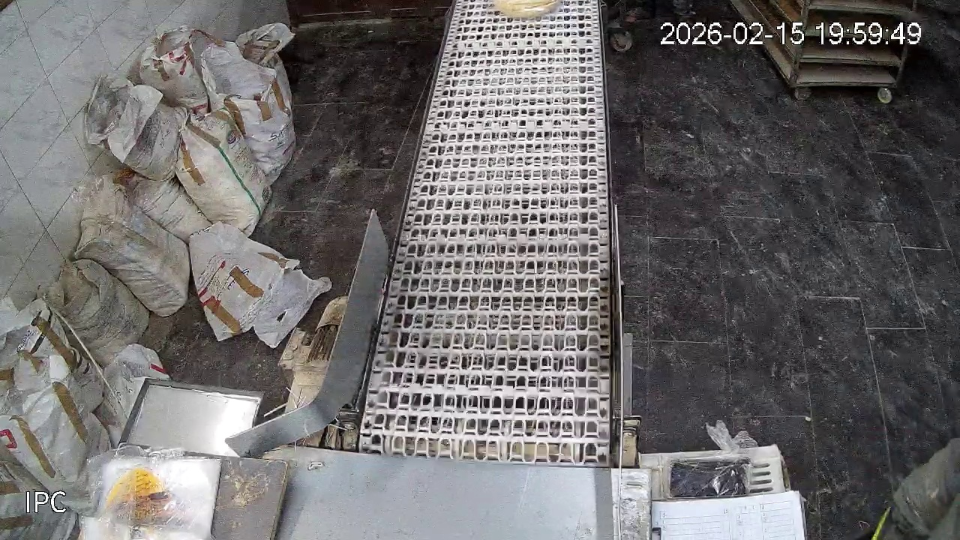

  (no detections — use 'add' to draw one)
💾 Checkpoint saved (4369 frames)
👋 Done.


In [23]:
annotate(
    model_path=r"data/model/yolo_nano_detect_v12.pt",           # your YOLO .pt weights
    video_path=r"D:\Recordings\2026_02_05\2026_02_16\output_2026-02-15_19-59-34.mp4",      # your video
    stride=14,                                    # every 5th frame
    conf=0.8,                                   # min confidence
    device="0",                                   # "" = auto, "cuda", "cpu"
    max_frames=None,                             # None = all frames
)

In [ ]:
from pathlib import Path

frames, cmap = load_checkpoint(Path("./annotation_workspace/checkpoint.json"))
export_yolo_dataset(frames, cmap, "./yolo_dataset", val_ratio=0.2)